In [262]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, ttest_ind
import statsmodels.api as smf

def simulate_random_walks(num_trials, drift1, drift2, alpha, pop_var, dependent=False):
    """Simulate two dependent random walks

    Args:
        num_trials (int): number of trials to simulate
        drift1 (int): drift of rw1
        drift2 (int):  drift of rw2
        alpha (int): multiplactive gain of walk 1 on walk 2
        pop_var (bool): if true, introduces random sampling to direction of gain b/w walk 1 and 2
        dependent (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """
    # Initialize arrays to store the random walks
    walk1 = np.zeros(num_trials)
    walk2 = np.zeros(num_trials)

    for step in range(1, num_trials):
        # Generate random steps
        step1 = np.random.normal()
        step2 = np.random.normal()

        # Add drift
        walk1[step] = walk1[step - 1] + drift1 + step1

        # Introduce randomness to dimensionality
        if pop_var is True:
            dim = 2 * np.random.sample() -1
        else: 
            dim = 1

        if dependent:
            # Make walk2 dependent on the previous timestep of walk1
            walk2[step] = walk2[step - 1] + drift2 + (alpha*dim) * walk1[step - 1] + step2
        else:
            walk2[step] = walk2[step - 1] + drift2 + step2
            
    correlation = stats.pearsonr(walk1, walk2)[0]

    return walk1, walk2, correlation

def random_walks_with_intervention(num_trials, intervention, gain, drift1, drift2):
    """Simulate two dependent random walks

    Args:
        num_trials (int): number of trials to simulate
        drift1 (int): drift of rw1
        drift2 (int):  drift of rw2
        alpha (int): multiplactive gain of walk 1 on walk 2
        pop_var (bool): if true, introduces random sampling to direction of gain b/w walk 1 and 2
        dependent (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """
    # Initialize arrays to store the random walks
    walk1 = np.zeros(num_trials)
    walk2 = np.zeros(num_trials)

    for step in range(1, num_trials):
        # Generate random steps
        step1 = np.random.normal()
        step2 = np.random.normal()

        # Add drift
        walk1[step] = walk1[step - 1] + drift1 + intervention[step-1] * gain + step1

        walk2[step] = walk2[step - 1] + drift2 + intervention[step-1] * gain + step2

    correlation = stats.pearsonr(walk1, walk2)[0]

    return walk1, walk2, correlation


def simulate_ar(n, phi):
    """Simulate autoregressive process

    Args:
        n (int): number of trials
        phi (_type_): _description_

    Returns:
        _type_: _description_
    """
    ar_process = [0]
    for _ in range(n):
        ar_process.append(phi * ar_process[-1] + np.random.normal())
    return ar_process[1:]

def sobel_test(a, b, se_a, se_b):
    '''
    Sobel test for significance of mediation
    
    Args: 
        a: coefficient from X to mediator variable, M
        b: coefficient from M to Y 
        se_a: Standard error of A
        se_b: Standard error fo B

    Returns: 
        t: Sobel's test statistic
        pval : Two-tailed probability assuming normal distribution
    '''
    
    sobel = np.sqrt( (a**2)*(se_a**2) + (b**2)*(se_b**2))
    aroian  = np.sqrt( (a**2)*(se_a**2) + (b**2)*(se_b**2) + (se_b**2) *(se_a**2)) #SE2 for arioni test
    t = (a*b) / aroian
    n = 1000000
    pval = stats.t.sf(np.abs(t), n-1)*2
    return t, pval

def mediation_tests(behavioural, neural, intervention):
    intervention = pd.DataFrame({'Intercept':np.ones(len(intervention)),'X':intervention})
    regression_a= smf.OLS(neural,intervention).fit()

    neural = pd.DataFrame({'Intercept':np.ones(len(neural)),'X':neural})
    regression_b = smf.OLS(behavioural, neural).fit()

    return regression_a, regression_b

def performMediation(num_tests, num_phis, num_trials, staticIntervention):
    """Simulate mediation analysis for different values of phi with interventions as static or variable

    Args:
        num_tests (_type_): _description_
        num_phis (_type_): _description_
        num_trials (_type_): _description_
        staticIntervention (_type_): _description_
    """
    phis = np.linspace(.7, 1, num_phis)
    num_significant_mediator = np.zeros(num_phis)
    num_significant1 = np.zeros(num_phis)
    num_significant2 = np.zeros(num_phis)

    num_significant_correlation = np.zeros(num_phis)
    num_trials = np.linspace(num_trials, num_trials, 1)
    mu, sigma = 0, 1  # Mean and standard deviation

    for num_trial in num_trials:

        num_trial = int(num_trial)
        ax = plt.figure()
        
        for num, phi in enumerate(phis):
            mediation_effects = np.zeros(num_tests)
            direct1_effects = np.zeros(num_tests)
            direct2_effects = np.zeros(num_tests)
            correlation_effects = np.zeros(num_tests)

            for test in range(num_tests):

                # Step 1: Generate three independent random walks
                
                if staticIntervention is True:
                    intervention = np.random.normal(mu, sigma, num_trial)
                else:
                    intervention = simulate_ar(n = num_trial, phi = phi)
                    
                neural= simulate_ar(n = num_trial, phi = phi)
                behavioural = simulate_ar(n = num_trial, phi = phi)

                # Step 2: Calculate Sobel test statistics
                # Calculate the direct effect of intervention on neural
                _, p_value_neural = ttest_ind(intervention, neural)

                # Calculate the effect of intervention on behaviour
                _, p_value_behaviour = ttest_ind(behavioural, intervention)

               # Calculate the effect of neural on behaviour
                _, p_value_corr = ttest_ind(behavioural, neural)


                # Step 3: Perform the Sobel test for mediation significance
                regression_a, regression_b = mediation_tests(behavioural, neural, intervention)

                t, p_value_sobel = sobel_test(regression_a.params[1], regression_b.params[1], 
                                    regression_a.bse[1], regression_b.bse[1])

                # Store p values for computing FP rate
                mediation_effects[test] = p_value_sobel
                direct1_effects[test] = p_value_neural
                direct2_effects[test] = p_value_behaviour
                correlation_effects[test] = p_value_corr

            # Compute FP rate for correlations and mediations
            num_significant1[num] = np.sum(direct1_effects < .05)
            num_significant2[num] = np.sum(direct2_effects < .05)
            num_significant_correlation[num] = np.sum(correlation_effects < .05)
            num_significant_mediator[num] = np.sum(mediation_effects < .05)


        # Plot proportion significant correlations/mediations by Phi value
        plt.plot(num_significant1/num_tests)
        plt.xlabel('Number of Trials')
        plt.xticks([0,25], labels = [0.7, 1])
        plt.plot(num_significant_mediator/num_tests)
        plt.xlabel('Phi')
        plt.ylabel('Proportion false positive')
        plt.plot(num_significant_correlation/num_tests)
        plt.plot(num_significant2/num_tests)
        plt.ylim([-.01, 1])

def simulatePvalues(staticIntervention, causal, drift1, drift2, num_experiments, gain, num_trials, phi):
    """_summary_

    Args:
        staticIntervention (_type_): _description_
        drift (_type_): _description_
        num_experiments (_type_): _description_
        num_trials (_type_): _description_
        phi (_type_): _description_
    """
    plt.figure()
    mu = 0
    sigma = 1
    pvals = np.zeros(num_experiments)

    for i in range(num_experiments):
        if staticIntervention is True:
            intervention = np.random.normal(mu, sigma, num_trials)
        else:
            intervention = simulate_ar(n = num_trials, phi = phi)
        
        if causal is True:
            neural, behavioural, _ = random_walks_with_intervention(num_trials, intervention, drift1 = drift1, drift2 = drift2, gain = gain)
            #neural, behavioural, _ = simulate_random_walks(num_trials, drift1 = np.mean(intervention)/10, 
                                                        #drift2 = np.mean(intervention)/10, alpha = 0, pop_var = False, dependent=False)
        else:
            neural, behavioural, _ = simulate_random_walks(num_trials, drift1 = drift1, 
                                                        drift2 = drift2, alpha = 0, pop_var = False, dependent=False)
            #neural, behavioural, _ = random_walks_with_intervention(num_trials, intervention, drift1 = 0, drift2 = 0)


        regression_a, regression_b = mediation_tests(behavioural, neural, intervention)

        t, pvals[i] = sobel_test(regression_a.params[1], regression_b.params[1], 
                                    regression_a.bse[1], regression_b.bse[1])
        
    plt.hist(pvals)
    plt.figure()
    plt.plot(intervention)
    plt.plot(neural)
    plt.plot(behavioural)


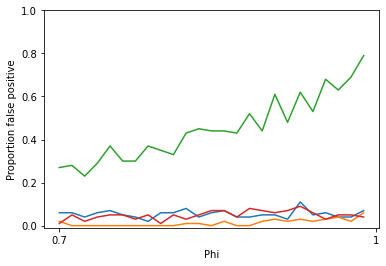

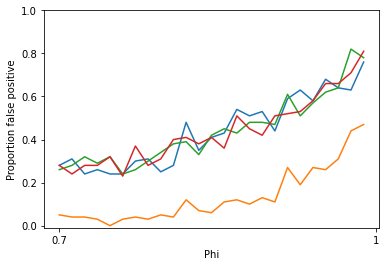

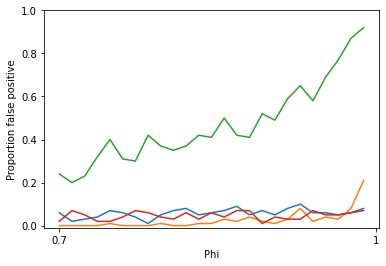

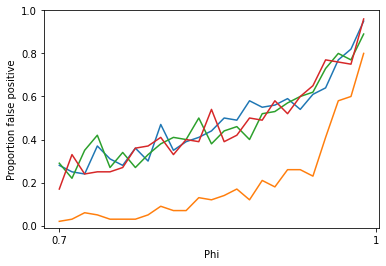

In [212]:
performMediation(num_tests = 100, num_phis = 25, num_trials = 100, staticIntervention = True)
performMediation(num_tests = 100, num_phis = 25, num_trials = 100, staticIntervention = False)
performMediation(num_tests = 100, num_phis = 25, num_trials = 1000, staticIntervention = True)
performMediation(num_tests = 100, num_phis = 25, num_trials = 1000, staticIntervention = False)

Text(0.5, 1.0, 'Static Intervention, Non-causal, High Phi')

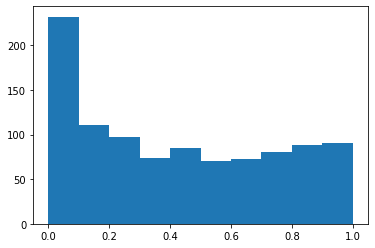

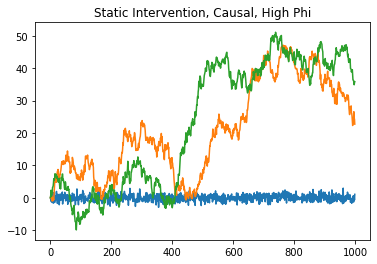

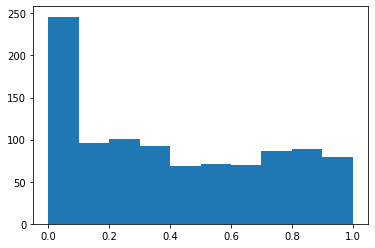

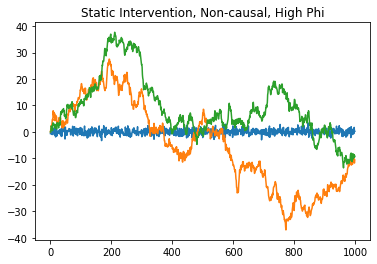

In [264]:
## Get distribution of p values for random walks with drift
simulatePvalues(staticIntervention = True, causal = True, drift1 = 0, drift2 = 0, 
                num_experiments = 1000, gain = .1, num_trials = 1000, phi = 1)
plt.title('Static Intervention, Causal, High Phi')

simulatePvalues(staticIntervention = True, causal = False, drift1 = 0, drift2 = 0, 
                num_experiments = 1000, gain = .1, num_trials = 1000, phi = 1)
plt.title('Static Intervention, Non-causal, High Phi')


Text(0.5, 1.0, 'Dynamic Intervention, Non-causal, High Phi')

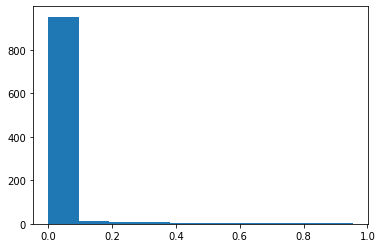

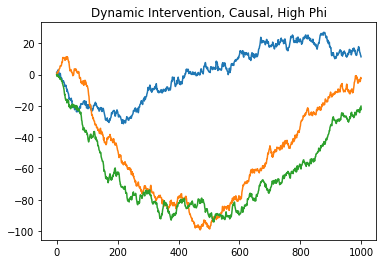

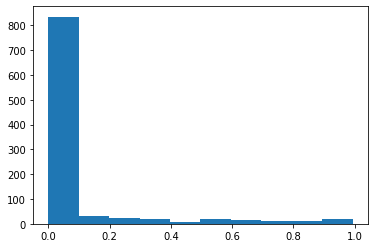

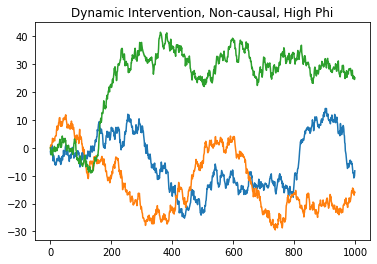

In [269]:
## Get distribution of p values for random walks with drift
simulatePvalues(staticIntervention = False, causal = True, drift1 = 0, drift2 = 0,
                num_experiments = 1000, gain = .01, num_trials = 1000, phi = 1)
plt.title('Dynamic Intervention, Causal, High Phi')
simulatePvalues(staticIntervention = False, causal = False, drift1 = 0, drift2 = 0, 
                num_experiments = 1000, gain = .01, num_trials = 1000, phi = 1)
plt.title('Dynamic Intervention, Non-causal, High Phi')


Text(0.5, 1.0, 'Dynamic Intervention, Dependent, Low Phi')

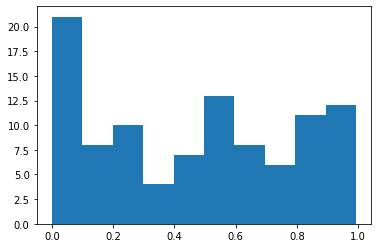

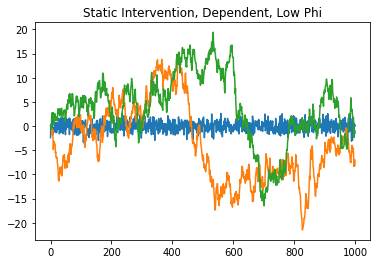

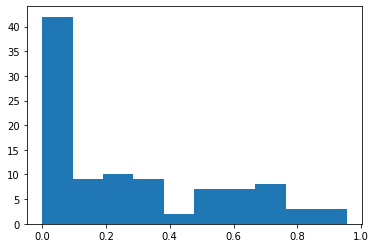

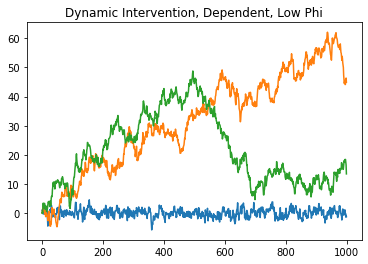

In [271]:
simulatePvalues(staticIntervention = True, num_experiments=100, drift1 = 0, drift2 = 0, 
                num_trials = 1000, gain = .01, phi = .7, causal = True)
plt.title('Static Intervention, Dependent, Low Phi')

simulatePvalues(staticIntervention = False, num_experiments=100, drift1 = 0, drift2 = 0, 
                 num_trials = 1000, gain = .01, phi = .7, causal = True)
plt.title('Dynamic Intervention, Dependent, Low Phi')


Text(0.5, 1.0, 'Dynamic Intervention, Independent, Low Phi')

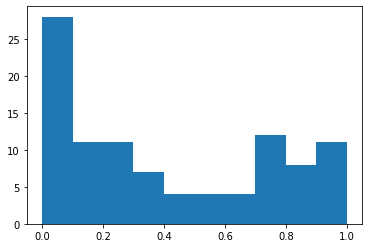

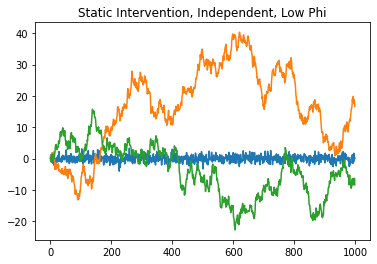

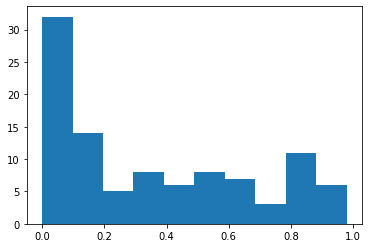

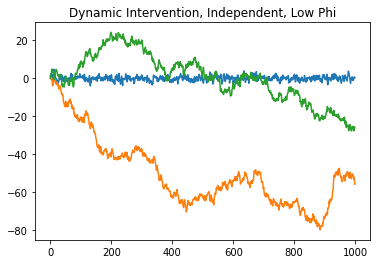

In [273]:
simulatePvalues(staticIntervention = True, num_experiments=100, drift1 = 0, drift2 = 0, 
                num_trials = 1000, phi = .5, gain = .01, causal = False)
plt.title('Static Intervention, Independent, Low Phi')
simulatePvalues(staticIntervention = False, num_experiments=100, drift1 = 0, drift2 = 0, 
                num_trials = 1000, phi = .5, gain = .01, causal = False)
plt.title('Dynamic Intervention, Independent, Low Phi')



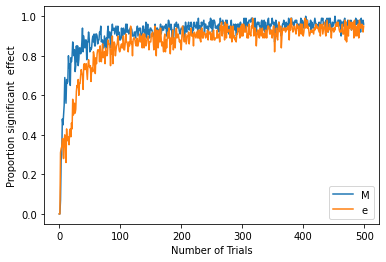

In [2]:
tests = 100
maxtrials = 500
exp_length = np.arange(2,maxtrials,1)
num_significant_mediator = np.zeros(maxtrials)
num_significant = np.zeros(maxtrials)
drift1 = 0
drift2 = 0
alpha = 0
pop_var = True

for num_trials in exp_length:
    mediation_effects = np.zeros(tests)
    direct_effects = np.zeros(tests)

    for test in range(tests):

        # Step 1: Generate three independent random walks
        mu, sigma = 1, 1  # Mean and standard deviation
        intervention = np.random.normal(mu, sigma, num_trials)
        neural, behavioural, _ = simulate_random_walks(num_trials, drift1, drift2, alpha, pop_var, dependent=True)

        # Step 2: Calculate Sobel test statistics
        # Calculate the direct effect of intervention on neural
        t_stat_direct, p_value_direct = ttest_ind(neural, intervention)

        # Calculate the effect of intervention on behaviour
        t_stat_mediator, p_value_mediator = ttest_ind(behavioural, intervention)

        # Calculate the effect of neural on behaviour
        t_stat_total, p_value_total = ttest_ind(behavioural, neural)

        # Step 3: Perform the Sobel test
        mediation_effect = t_stat_direct * t_stat_mediator / t_stat_total
        z_value = np.abs(mediation_effect) / np.sqrt(
            (t_stat_direct**2 / (len(intervention) - 1)) + (t_stat_mediator**2 / (len(behavioural) - 1))
        )
        p_value_sobel = 2 * (1 - norm.cdf(np.abs(z_value)))
        
        mediation_effects[test] = p_value_sobel
        direct_effects[test] = p_value_direct

    num_significant[num_trials] = np.sum(direct_effects < .05)
    num_significant_mediator[num_trials] = np.sum(mediation_effects < .05)


plt.plot(num_significant/tests)
plt.xlabel('Number of Trials')
plt.legend('Direct')
plt.plot(num_significant_mediator/tests)
plt.xlabel('Number of Trials')
plt.ylabel('Proportion significant  effect')
plt.legend('Mediation')

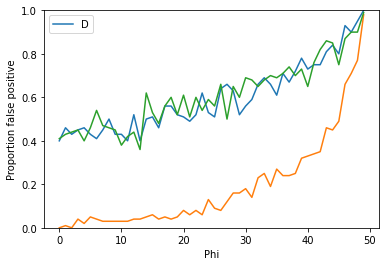

In [130]:
tests = 100
num_phis = 50
phis = np.linspace(.7, 1, num_phis)
num_significant_mediator = np.zeros(num_phis)
num_significant = np.zeros(num_phis)
num_significant_correlation = np.zeros(num_phis)
num_trials = np.linspace(10000, 10000, 1)

for num_trial in num_trials:
    num_trial = int(num_trial)
    plt.figure()
    for num, phi in enumerate(phis):
        mediation_effects = np.zeros(tests)
        direct_effects = np.zeros(tests)
        correlation_effects = np.zeros(tests)

        for test in range(tests):

            # Step 1: Generate three independent random walks
            mu, sigma = 0, 1  # Mean and standard deviation
            #intervention = np.random.normal(mu, sigma, num_trial)
            intervention = simulate_ar(n = num_trial, phi = phi)
            neural= simulate_ar(n = num_trial, phi = phi)
            behavioural = simulate_ar(n = num_trial, phi = phi)

            # Step 2: Calculate Sobel test statistics
            # Calculate the direct effect of intervention on neural
            t_stat_direct, p_value_direct = ttest_ind(intervention, neural)

            # Calculate the effect of neural on behaviour
            t_stat_total, p_value_total = ttest_ind(behavioural, intervention)

            # Step 3: Perform the Sobel test
            regression_a, regression_b = mediation_tests(behavioural, neural, intervention)

            t, p_value_sobel = sobel_test(regression_a.params[1], regression_b.params[1], 
                                 regression_a.bse[1], regression_b.bse[1])

            mediation_effects[test] = p_value_sobel
            direct_effects[test] = p_value_direct
            correlation_effects[test] = p_value_total

        num_significant[num] = np.sum(direct_effects < .05)
        num_significant_mediator[num] = np.sum(mediation_effects < .05)
        num_significant_correlation[num] = np.sum(correlation_effects < .05)


    plt.plot(num_significant/tests)
    plt.xlabel('Number of Trials')
    plt.legend('Direct')
    plt.plot(num_significant_mediator/tests)
    plt.xlabel('Phi')
    plt.ylabel('Proportion false positive')
    plt.plot(num_significant_correlation/tests)
    plt.ylim([0, 1])


## What this means: effect of intervention has to have a constant relationship b/w neural and behavioural activity for mediation to work
    

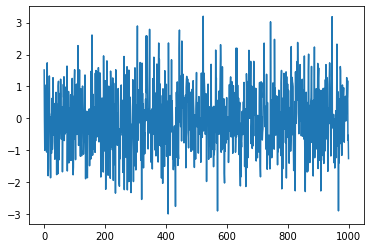

In [22]:
## Plot white noies for figure making

mean = 0
std = 1 
num_samples = 1000
samples = np.random.normal(mean, std, size=num_samples)

plt.plot(samples)
plt.savefig(rf'C:\Users\Brandon\Desktop\PhD\Ergodicity\Figures\whitenoise', format = 'svg')